# CNN first model

Here I use a network doing a CNN over the input. The model architecture is a CNN of the local features. These then get pooled down to the number of channels, which is then fed into a dense layer.

### Load Libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch import nn, optim, cuda
from torch.utils.data.dataloader import DataLoader
from utils import Runner, EarlyStopping, TcrDataset, setup_seed
from cnn_network import CdrCNN

Set general plotting parameters for matplotlib using seaborn

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette="pastel")

### General parameters

In [3]:
# General parameters
data_dir = "../../data/"
data_files = [data_dir+f"datasets/P{i}_input_cdrs.npz" for i in range(1,6)]
label_files = [data_dir+f"datasets/P{i}_labels.npz" for i in range(1,6)]
model_name = "cdr_model.pt"
model_path = "stored_models/"

batch_size = 64
seed= 123

setup_seed(seed)
device = torch.device("cuda" if cuda.is_available() else "cpu")
#device= torch.device("cpu")

## Define indexing

In [4]:

########### Select Indexes TCR DATA ############

# Full model
#idx = np.arange(420)

# peptide + TCR
#idx = np.arange(179,420)

# MHC + TCR
#idx = np.concatenate([np.arange(179),np.arange(192,420)])

# TCR
#idx = np.arange(192,420)

# MHC + peptide
#idx = np.arange(192)


########### Select Indexes CDR Data ############

# Full model
# idx = np.arange(248)

# Peptide + All CDRS
idx = np.arange(179,248)

########### Select Features ###########

# All features
#local_features = np.arange(27)
#global_features = np.arange(27, 54)
#use_global_features = True

# Sequence
local_features = np.arange(20)
global_features = None
use_global_features = False

# Energy terms
#local_features = np.arange(20, 27)
#global_features = np.arange(27, 54)
#use_global_features = True

# Sequence and global energy
#local_features = np.arange(20)
#global_features = np.arange(27, 54)
#use_global_features = True


## Load Data
Partitions can be changed by altering the `data_files` and `label_files` indexing

In [5]:
train_data = TcrDataset(data_files[0], label_files[0])
train_data.add_partition(data_files[1], label_files[1])
train_data.add_partition(data_files[2], label_files[2])
val_data = TcrDataset(data_files[3], label_files[3])
test_data = TcrDataset(data_files[4], label_files[4])


# Shuffle data randomly is needed
train_data.shuffle_data()
val_data.shuffle_data()
test_data.shuffle_data()

# slicing sequence dimension
train_data.slice_sequences(idx)
val_data.slice_sequences(idx)
test_data.slice_sequences(idx)

train_data.to_blossum()
val_data.to_blossum()
test_data.to_blossum()

input_len = train_data.data.shape[2]


In [6]:
train_dl = DataLoader(train_data, batch_size)
val_dl = DataLoader(val_data, batch_size)
test_dl = DataLoader(test_data, batch_size)

In [7]:
len(train_data), len(val_data), len(test_data)

(4174, 1532, 1207)

In [8]:
train_data.data.shape

(4174, 54, 69)

In [9]:
#Hyperparameters
epochs = 100
patience = 20
lr = 0.005
loss_weight = sum(train_data.labels) / len(train_data.labels)
weight_decay = 0.0005

# Layer parameters
cnn_channels = 20
hidden_neurons = 64
dropout = 0.4
cnn_kernel = 3

# Loss and optimizer
criterion = nn.BCELoss(reduction='none')
stopper = EarlyStopping(patience, model_name, model_path)


In [10]:
net = CdrCNN(local_features, global_features, use_global_features, cnn_channels=cnn_channels, dropout=dropout, cnn_kernel_size=cnn_kernel, dense_neurons=hidden_neurons)
net.to(device)
print(net)
print("Using Device:", device)
optimizer = optim.Adam(net.parameters(), lr=lr,
    weight_decay=weight_decay,
    amsgrad=True
)

CdrCNN(
  (cdr1a_conv): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=same)
  (cdr2a_conv): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=same)
  (cdr3a_conv): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=same)
  (cdr1b_conv): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=same)
  (cdr2b_conv): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=same)
  (cdr3b_conv): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=same)
  (pep_conv): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=same)
  (max_pool): AdaptiveMaxPool1d(output_size=1)
  (max_pool_index): AdaptiveMaxPool1d(output_size=1)
  (dense1): Linear(in_features=60, out_features=64, bias=True)
  (dense_out): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (bn_dense): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_start): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
U

In [11]:
# Define runners
train_runner = Runner(train_dl, net, criterion, loss_weight, device, optimizer)
val_runner = Runner(val_dl, net, criterion, loss_weight, device)
test_runner = Runner(test_dl, net, criterion, loss_weight, device)

## Training Loop

In [12]:
train_loss, val_loss, train_auc, val_auc = [], [], [], []

for epoch in range(1, epochs+1):
    train_runner.run_epoch()
    val_runner.run_epoch()
    
    train_runner.follow_performance(epoch)
    val_runner.follow_performance(epoch)
    stopper.evaluate_epoch(val_runner.loss, net, epoch)
    
    train_loss.append(train_runner.loss)
    val_loss.append(val_runner.loss)
    train_auc.append(train_runner.auc)
    val_auc.append(val_runner.auc)
    
    train_runner.reset()
    val_runner.reset()

    if stopper.stop:
        break


Epoch: 1
Train loss: 0.29412263812440814 Train MCC: 0.05977939489416477 Train AUC: 0.5448291795667533
Validation loss: 0.2549169858296712 Validation MCC: 0.08368553155607515 Validation AUC: 0.6645363092438198
Validation loss decreased. Counter reset
Epoch: 2
Train loss: 0.2623041037357215 Train MCC: 0.1269711650984793 Train AUC: 0.5984166292839931
Validation loss: 0.25772492090861004 Validation MCC: 0.040211326504912645 Validation AUC: 0.6857285367909887
Early Stopping Counter: 1 out of 20
Epoch: 3
Train loss: 0.24696118903882575 Train MCC: 0.1988189838578727 Train AUC: 0.6528621952086443
Validation loss: 0.24685062964757284 Validation MCC: 0.11581743490724115 Validation AUC: 0.6864534264100693
Validation loss decreased. Counter reset
Epoch: 4
Train loss: 0.24402005744702887 Train MCC: 0.221573970179803 Train AUC: 0.6623952365894255
Validation loss: 0.2556722164154053 Validation MCC: 0.04703498159755505 Validation AUC: 0.6911663451247196
Early Stopping Counter: 1 out of 20
Epoch: 5
Tra

(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'))

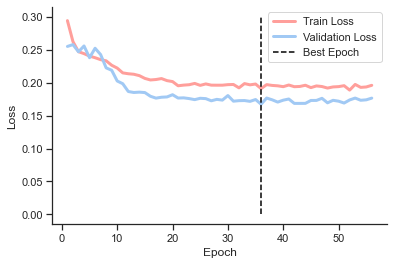

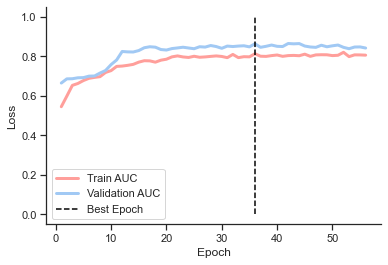

In [28]:
# Plots of training epochs
epoch = np.arange(1, len(train_loss) + 1)
plt.figure()
plt.plot(epoch, train_loss, "r", epoch, val_loss, "b", linewidth=3)
plt.vlines(stopper.best_epoch, ymin=0, ymax=0.3, colors="black", linestyles='dashed')
plt.legend(["Train Loss", "Validation Loss", "Best Epoch"])
plt.xlabel("Epoch"), plt.ylabel("Loss")

epoch = np.arange(1, len(train_loss) + 1)
plt.figure()
plt.plot(epoch, train_auc, "r", epoch, val_auc, "b", linewidth=3)
plt.vlines(stopper.best_epoch, ymin=0, ymax=1, colors="black", linestyles='dashed')
plt.legend(["Train AUC", "Validation AUC", "Best Epoch"])
plt.xlabel("Epoch"), plt.ylabel("Loss")

## Evaluate using the best model

Best model is stored as early_stopping_state.pt and loaded into a new object

In [29]:
final_model = CdrCNN(local_features, global_features, use_global_features, cnn_channels=cnn_channels, dropout=dropout, cnn_kernel_size=cnn_kernel, dense_neurons=hidden_neurons)
final_model.load_state_dict(torch.load(model_path + model_name))
final_model.to(device)

train_runner.model = final_model
val_runner.model = final_model
test_runner.model = final_model

In [30]:
train_runner.reset()
val_runner.reset()
test_runner.reset()

train_runner.evaluation_mode() # Set to validation to avoid more training
train_runner.run_epoch()
val_runner.run_epoch()
test_runner.run_epoch()

Evaluation on Training Data:
Loss: 0.15770936734748608
MCC: 0.6156968902060771
Confussion Matrix:
 [[2844  288]
 [ 309  733]] 

Evaluation on Validation Data:
Loss: 0.16721993684768677
MCC: 0.5532531406216785
Confussion Matrix:
 [[1031  118]
 [ 135  248]] 

Evaluation on Test Data:
Loss: 0.18505769026906868
MCC: 0.5214392859299398
Confussion Matrix:
 [[815  91]
 [119 182]] 



Text(0.5, 1.0, 'Test Data')

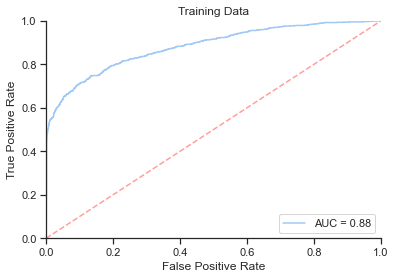

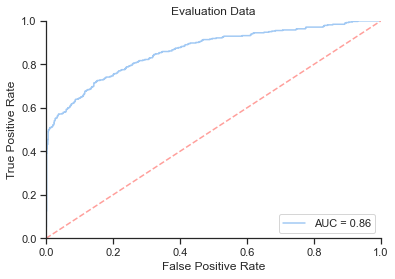

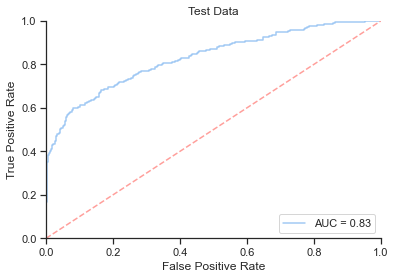

In [31]:
print("Evaluation on Training Data:")
train_runner.evaluate_model()
plt.title("Training Data")

print("Evaluation on Validation Data:")
val_runner.evaluate_model()
plt.title("Evaluation Data")

print("Evaluation on Test Data:")
test_runner.evaluate_model()
plt.title("Test Data")
